# ParseGA
### Created on Tue Apr 28 2020 by Nicola
### Ammended for patient data on Apr 9 2024 by Anita
Parse GA output data and export as csv. 
- Select GA.csv files
- Select output directory

In [17]:
from pathlib import PurePath
import os
import numpy as np
import csv
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.pyplot import subplots
import re

In [2]:
#inspect files for duplicates / incomplete trials
data_dir = os.getcwd() + '/raw_data'
file_list = [f for f in os.listdir(data_dir) if not f.startswith('.')]

dup_list = [f for f in file_list if f.endswith('2.csv')]

rm_list = [re.sub('output_2', 'output_1', i) for i in dup_list]

file_list=set(file_list)-set(rm_list)

filename = [data_dir+"/"+filename for filename in file_list]

outputDir = os.getcwd() + '/parsed'

In [3]:
print(len(file_list))

140


In [4]:
for file in filename:

    # set path
    path = PurePath(file)
    
    data=[]
    with open(file, 'r') as f:
        reader=csv.reader(f)
        for row in reader:
            data.append(row)
    
    # find indices
    iGeneration=[]
    iElite=[]
    iSelected=[]
            
    nRows=len(data)
    for row in range(nRows):
        if data[row][0]=='Generation number':
            iGeneration.append(row)
        if data[row][0]=='elite face':
            iElite.append(row)
        if data[row][0]=='selected faces':
            iSelected.append(row)
            
    # constants
    nFaces=len(data[1])-2
    nFeatures=(iGeneration[2]-1) - (iGeneration[1]+3)+1
    fName=[]
    for d in range(nFeatures):
        fName.append(data[3+d][1])
    fName.extend(["faceID","faceSelected","eliteSelected","nGeneration"])
    
    # rearrange data 
    dataParsed=pd.DataFrame()
    for g in range(len(iGeneration)):
        
        # selected and elite labels   
        faceID=list(range(1,nFaces+1))
        selected=data[iSelected[g]][2:]
        elite=data[iElite[g]][2:]
        
        
        # get weights
        weights=[]
        for d in range(nFeatures):
            weights.append(data[iGeneration[g]+3+d][2:])
        
        # generation number vector
        gList=np.repeat(g+1,nFaces)
        
        # append parsed data
        df=pd.concat([pd.DataFrame(weights).T,pd.Series(faceID), pd.Series(selected), pd.Series(elite), pd.Series(gList)], axis=1)
        dataParsed=pd.concat([dataParsed, df])
        
    # export data
    dataParsed.columns = fName
    outputName=outputDir + '/' + os.path.split(file)[1].split('.')[0] + '_parsed.csv'
    dataParsed.to_csv(outputName,index=False)

In [5]:
test = pd.read_csv('parsed/S1HC02_Angry_output_1_parsed.csv')
test['nGeneration'].unique() #check how many trials/iterations there were

array([1, 2, 3, 4, 5, 6, 7, 8])

# Generate subject-wise elite csv
### Created on Tue May 10 2022 by Tom

Generic script to take final generation face (elite) from parsed files, and output
into a single csv, with label for file name.

In [6]:
# Select generation N (start from 1)
nGen = 8

# Set data directory
data_dir = os.getcwd() + '/parsed'

# list of all files in directory
file_list = [f for f in os.listdir(data_dir) if not f.startswith('.')]

# Construct dataframe
full_df = pd.DataFrame()
for file in file_list:
    # read csv
    file_df = pd.read_csv(data_dir + '//' + file)
    
    # get dataframe with single row containing elite
    elite_df = file_df[
        (file_df['eliteSelected'] == 1) & (file_df['nGeneration'] == nGen)
        ]
    
    # remove columns for face number/selection etc
    elite_df = elite_df[elite_df.columns[0:150]]
    
    # add column for file name
    elite_df.insert(150, 'file', file)
    
    # concatenate with full dataframe
    full_df = pd.concat([full_df, elite_df], ignore_index=True)

#save
full_df.to_csv('processed_data/all_elites.csv', index = False)

# Code file names
### Created on Tue May 10 2022 by Tom

Script to split the file names in the generic elite csv, and add columns 
specifying ID, conditions, etc.

Note - this script currently works with the file names as output in the offline
data. Will need to amend to suit the format of the file names you use

### Ammended for patient data on 6 March 2024 by Anita

In [7]:
# get elite df
elite_df=pd.read_csv('processed_data/all_elites.csv')

def get_file_info(file_name):
    ID = file_name.split('_')[0] #ID (string)
    emo = file_name.split('_')[1] #target emo
    return ID, emo

# loop through elites
ID_list = []
emo_list = []
for idx in elite_df.index:
    file_name = elite_df.iloc[idx]['file']
    ID, emo = get_file_info(file_name)
    emo_list.append(emo)
    ID_list.append(ID)

# add to dataframe
elite_df['TargetEmotion'] = emo_list
elite_df['ID'] = ID_list
elite_df['Group'] = elite_df['ID'].str.extract(r'S1([A-Z][A-Z])')

#save coded elite_df as a csv
elite_df.to_csv('processed_data/all_elites_coded.csv', index = False)

# Visualise random sample and average elite face for patients and controls
Group data by:
- clinical group - patients (PT) and healthy controls (HC)
- target emotion - angry, fearful, happy
### created by Anita on 06 March 2024

In [8]:
#sample subject elite face for visualisation
rand_sub = elite_df['ID'].iloc[102]
elite_sample_sub = elite_df.loc[elite_df['ID'] == rand_sub].drop(elite_df.columns[[0, -1, -2, -3, -4]], axis = 1)

#save
elite_sample_sub.to_csv('processed_data/sample_sub_elites.csv', index = False, header = False)

In [9]:
#calculate mean for each emotion for each group
avg_elite = elite_df.drop(['file', 'ID'], axis=1).groupby(['Group', 'TargetEmotion'], observed=True).mean()

avg_elite_all = elite_df.drop(['file', 'ID','Group'], axis=1).groupby(['TargetEmotion'], observed=True).mean()

#save averaged elite faces as csv file for visualisation
avg_elite.to_csv('processed_data/avg_elites_within.csv', index = False, header = False)
avg_elite_all.to_csv('processed_data/avg_elites_across.csv', index = False, header = False)

# Perform PCA

### Created on Jun 16 2022 by Tom

Script to calculate distances of each face from:
- centroid
- neutral

### Modified for patient data on 12 March 2024 by Anita

In [10]:
core_BS_df = pd.read_csv('processed_data/CoreBlendshapeListWithFACS.csv') # core blendshape list

#manually insert vector corresponding to FACS number to show clusters
AUs = 26, 30, 30, 29, 'NaN', 17, 28, 28, 23, 23, 22, 22, 10, 9, 16, 21, 11, 20, 18, 27, 12, 14, 15, 13, 34, 33, 31, 80, 38, 39, 1, 2, 4, 'NaN', 44, 5, 41, 42, 'NaN', 7, 6
len(AUs)

core_BS_df['AUs'] = AUs
core_BS_df['AUs'] = core_BS_df['AUs'].astype(float)

ordered_core = core_BS_df.sort_values(by=['AUs']).reset_index()['Blendshape index']

Kaiser criterion suggests choosing 17 components
17 components explain 67.551% of variance


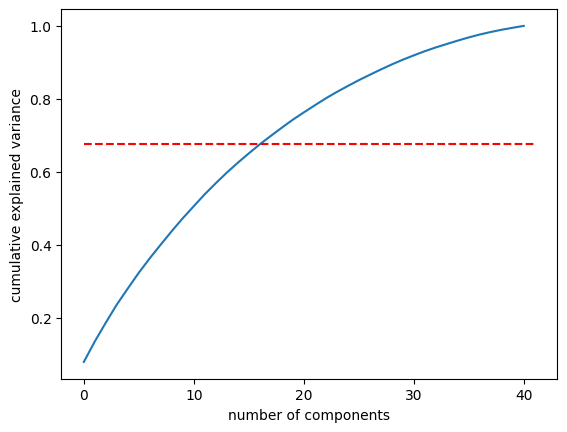

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance

#import data
elite_df = pd.read_csv('processed_data/all_elites_coded.csv') # elites
elite_core_df = elite_df[elite_df.columns[core_BS_df['Blendshape index']]] # get core

#run PCA
X = elite_core_df.values # get matrix
X = StandardScaler().fit_transform(X) # standardise

pca = PCA() # pca model
principalComponents = pca.fit_transform(X) # fit data

# number of components
n_comp = np.count_nonzero([pca.explained_variance_ > 1])
comp_labels = ['PC' + str(x) for x in range(1,n_comp+1)]
orig_eigenvalues = pca.explained_variance_ratio_

# print
print(f'Kaiser criterion suggests choosing {n_comp} components')

# PCA with n components
pca = PCA(n_components = n_comp)
principalComponents = pca.fit_transform(X)
print(f'{n_comp} components explain {sum(pca.explained_variance_ratio_)*100:.3f}% of variance')

PC_df = pd.DataFrame(data = principalComponents, columns = comp_labels)
full_df = pd.concat([elite_df, PC_df], axis = 1) # concatenated elite + PC dataframes

plt.plot(np.cumsum(orig_eigenvalues))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.hlines(y=sum(pca.explained_variance_ratio_), xmin=0, xmax=len(orig_eigenvalues), color='r', linestyles="dashed");

In [76]:
elite_df.loc[:, 1:150]

TypeError: cannot do slice indexing on Index with these indexers [1] of type int

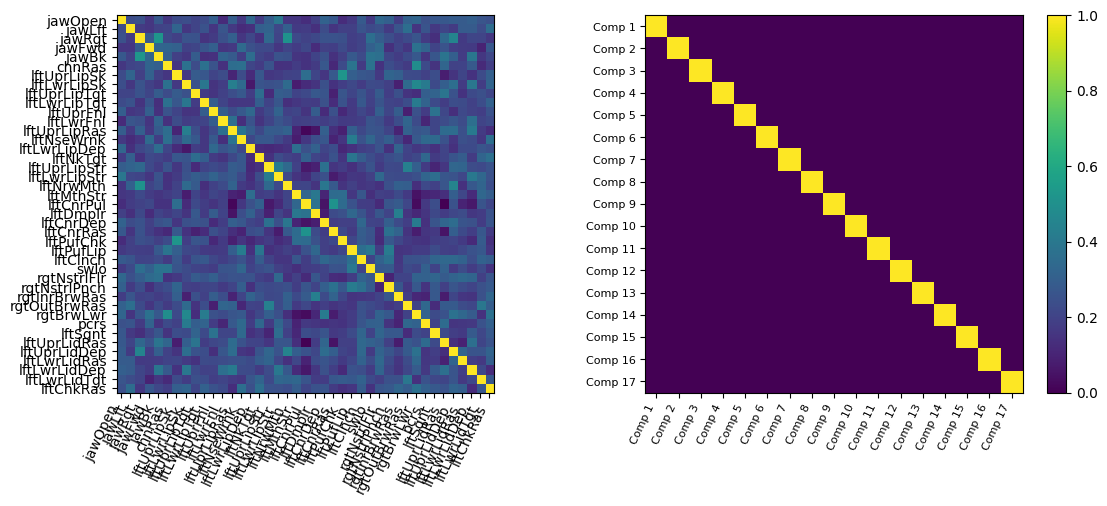

In [71]:
#add correlation matrix before and after dimensionality reduction to show how the correlation between features changes

blendshapes=elite_core_df.columns
nFeatures=len(blendshapes)
nComp=np.shape(principalComponents)[1]

fig, ax = subplots(1, 2, figsize=(10, 5))

im1 = ax[0].imshow(elite_core_df.corr())
ax[0].set_xticks(range(int(nFeatures)),blendshapes[0:int(nFeatures)],rotation=65,ha='right')
ax[0].set_yticks(range(int(nFeatures)),blendshapes[0:int(nFeatures)])
#plt.colorbar();

im2 = ax[1].imshow(PC_df.corr())
ax[1].set_xticks(range(nComp),['Comp ' + str(i) for i in range(1, nComp+1)],fontsize=8, rotation=65,ha='right')
ax[1].set_yticks(range(nComp),['Comp ' + str(i) for i in range(1, nComp+1)],fontsize=8);
cbar = fig.colorbar(im2, ax=ax[1])
fig.tight_layout(rect=[0, 0, 1.2, 1]);


# Visualise PCA
### Created by Anita on Apr 4 2024

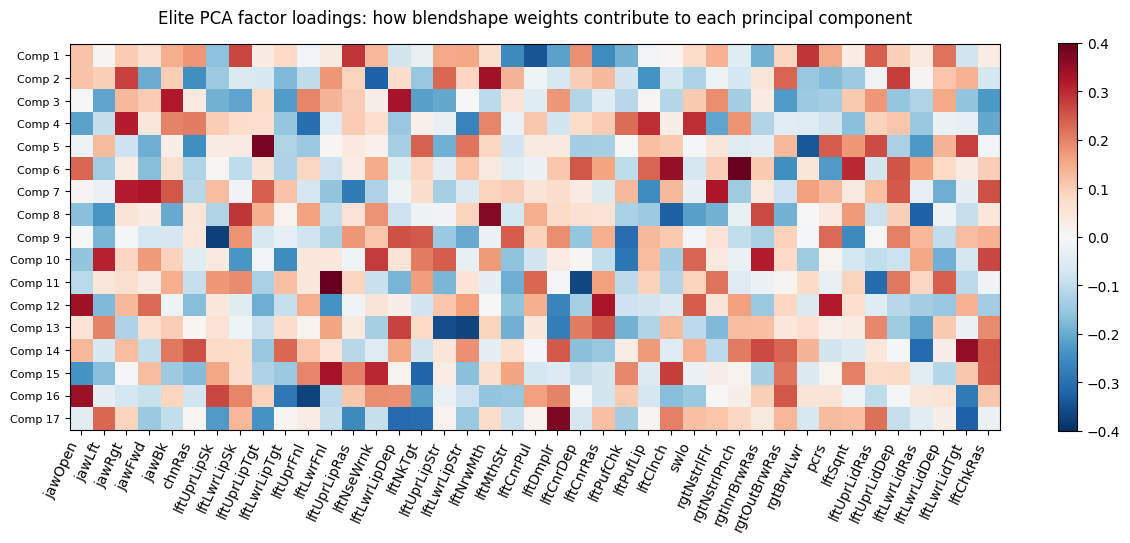

In [72]:
blendshapes=elite_core_df.columns
nFeatures=len(blendshapes)
nComp=np.shape(principalComponents)[1]

plt.imshow(pca.components_[:,0:int(nFeatures)],cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.xticks(range(int(nFeatures)),blendshapes[0:int(nFeatures)],rotation=65,ha='right')
    
plt.yticks(range(nComp),['Comp ' + str(i) for i in range(1, nComp+1)],fontsize=8)
plt.colorbar(shrink=.72)

#plt.tight_layout()
plt.gcf().set_size_inches(15,7)
plt.title('Elite PCA factor loadings: how blendshape weights contribute to each principal component', pad=15);

plt.savefig('plots/elite_PCA_factor_loadings.png', dpi=300, bbox_inches = 'tight')

# Calculate distances

### Created on Jun 16 2022 by Tom

Script to calculate distances of each face from:
- centroid
- neutral

### Modified for patient data on 12 March 2024 by Anita

In [92]:
# Euclidean Distance from true neutral
dists = []
neutral = np.zeros((1,n_comp)).ravel() # vector of zeros
for i in np.arange(PC_df.shape[0]): # for each face
    comps = PC_df.iloc[i][comp_labels].values
    #dists = pd.concat([pd.Series(distance.euclidean(comps, neutral))], axis = 1)
    dists.append(distance.euclidean(comps, neutral)) # calculate distance
full_df = pd.concat([full_df, pd.Series(dists)], axis = 1) # add to dataframe
full_df.rename(columns={full_df.columns[-1]: "Neutral_euclidean_distance" }, inplace = True)

In [94]:
# Cosine Distance from true neutral
dists = []
neutral = 1e-12*np.ones((1,n_comp)).ravel() # vector of zeros (small epsilon in order to avoid division by zero error for cosine distance)
for i in np.arange(PC_df.shape[0]): # for each face
    comps = PC_df.iloc[i][comp_labels].values
    dists.append(distance.cosine(comps, neutral)) # calculate distance
full_df['Neutral_cosine_distance'] = dists # add to dataframe

# Cosine Distance from true neutral
dists = []
neutral = np.zeros((1,n_comp)).ravel() # vector of zeros (small epsilon in order to avoid division by zero error for cosine distance)
for i in np.arange(PC_df.shape[0]): # for each face
    comps = PC_df.iloc[i][comp_labels].values
    dists.append(distance.cosine(comps, neutral)) # calculate distance
full_df['Neutral_cosine_distance'] = dists # add to dataframe

In [96]:
#%% Euclidean distance from Centroid

# average principal components
angry_mean_PC   = np.mean(full_df[full_df['TargetEmotion']=='Angry'][comp_labels].values, axis = 0)
fearful_mean_PC = np.mean(full_df[full_df['TargetEmotion']=='Fearful'][comp_labels].values, axis = 0)
happy_mean_PC     = np.mean(full_df[full_df['TargetEmotion']=='Happy'][comp_labels].values, axis = 0)

# Loop through dataframe
distances = []
for i in full_df.index:
    PCs = full_df.iloc[i][comp_labels].values
    if full_df.iloc[i]['TargetEmotion'] == 'Angry':
        dist = distance.euclidean(PCs, angry_mean_PC)
    elif full_df.iloc[i]['TargetEmotion'] == 'Fearful':
        dist = distance.euclidean(PCs, fearful_mean_PC)
    elif full_df.iloc[i]['TargetEmotion'] == 'Happy':
        dist = distance.euclidean(PCs, happy_mean_PC)
    
    distances.append(dist)
full_df['Centroid_euclidean_distance'] = distances


In [98]:
#%% Cosine distance from Centroid

# average principal components
angry_mean_PC   = np.mean(full_df[full_df['TargetEmotion']=='Angry'][comp_labels].values, axis = 0)
fearful_mean_PC = np.mean(full_df[full_df['TargetEmotion']=='Fearful'][comp_labels].values, axis = 0)
happy_mean_PC     = np.mean(full_df[full_df['TargetEmotion']=='Happy'][comp_labels].values, axis = 0)

# Loop through dataframe
distances = []
for i in full_df.index:
    PCs = full_df.iloc[i][comp_labels].values
    if full_df.iloc[i]['TargetEmotion'] == 'Angry':
        dist = distance.cosine(PCs, angry_mean_PC)
    elif full_df.iloc[i]['TargetEmotion'] == 'Fearful':
        dist = distance.cosine(PCs, fearful_mean_PC)
    elif full_df.iloc[i]['TargetEmotion'] == 'Happy':
        dist = distance.cosine(PCs, happy_mean_PC)
    
    distances.append(dist)
full_df['Centroid_cosine_distance'] = distances

#save
full_df.to_csv('processed_data/all_elite_distances.csv')

In [110]:
#calculate mean for each emotion for each group
avg_elite_dist = full_df.drop(['file', 
                               'ID'], axis=1).groupby(['Group', 
                                                       'TargetEmotion'], 
                                                      observed=True).agg({'Neutral_euclidean_distance':['mean', 'std'],
                                                                          'Centroid_euclidean_distance':['mean', 'std'],
                                                                          'Neutral_cosine_distance':['mean', 'std'],
                                                                          'Centroid_cosine_distance':['mean', 'std']})

avg_elite_dist.to_csv('processed_data/average_elite_distances.csv')

len(full_df['ID'].unique())

47